<a href="https://colab.research.google.com/github/marziehamiri/computer-vision/blob/main/Marzieh_Amiri_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This chapter will show you how to detect the features of an image with OpenCV and make
use of them to match and search images. Over the course of this chapter, we will take
sample images and detect their main features, and then try to find a region of another
image that matches the sample image. We will also find the homography or spatial
relationship between a sample image and a matching region of another image.

More specifically, we will cover the following tasks:
  * Detecting keypoints and extracting local descriptors around the keypoints using any of the following algorithms: Harris corners, SIFT, SURF, or ORB
  * Matching keypoints using brute-force algorithms or the FLANN algorithm
  * Filtering out bad matches using KNN and the ratio test
  * Finding the homography between two sets of matching keypoints
  * Searching a set of images to determine which one contains the best match for a
reference image

Technical requirements
This chapter uses Python, OpenCV, and NumPy. In regards to OpenCV, we use the
optional opencv_contrib modules, which include additional algorithms for keypoint
detection and matching. To enable the SIFT and SURF algorithms (which are patented and
not free for commercial use), we must configure the opencv_contrib modules with
the OPENCV_ENABLE_NONFREE flag in CMake. Please refer to Chapter 1, Setting Up
OpenCV, for installation instructions. Additionally, if you have not already installed
Matplotlib, install it by running $ pip install matplotlib (or $ pip3 install
matplotlib, depending on your environment).


Understanding types of feature detection
and matching
A number of algorithms can be used to detect and describe features, and we will explore
several of them in this section. The most commonly used feature detection and descriptor
extraction algorithms in OpenCV are as follows:
  * Harris: This algorithm is useful for detecting corners.
  * SIFT: This algorithm is useful for detecting blobs.
  * SURF: This algorithm is useful for detecting blobs.
  * FAST: This algorithm is useful for detecting corners.
  * BRIEF: This algorithm is useful for detecting blobs.
  * ORB: This algorithm stands for Oriented FAST and Rotated BRIEF. It is useful
for detecting a combination of corners and blobs.

Defining features
What is a feature, exactly? Why is a particular area of an image classifiable as a feature,
while others are not? Broadly speaking, a feature is an area of interest in the image that is
unique or easily recognizable. **Corners** and regions with a high density of textural detail are
good features, while patterns that repeat themselves a lot and low-density regions (such as
a blue sky) are not. Edges are good features as they tend to divide two regions of an image.
A **blob** (a region of an image that greatly differs from its surrounding areas) is also an
interesting feature.

Detecting Harris corners
OpenCV has a handy function called cv2.cornerHarris, which detects corners in an
image. We can see this function at work in the following basic example:

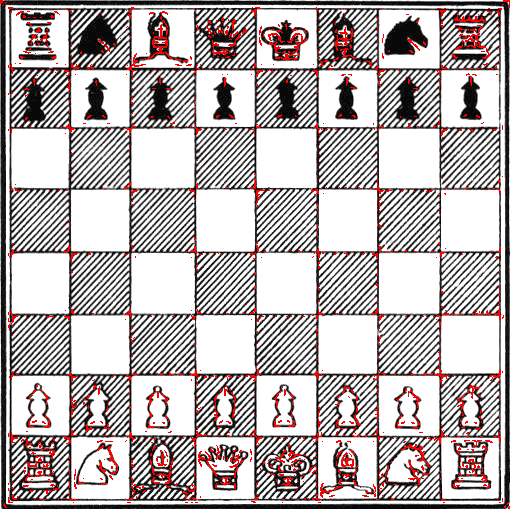

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/images/chess_board.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray, 2, 23, 0.04)
img[dst > 0.01 * dst.max()] = [0, 0, 255]
cv2_imshow( img)
cv2.waitKey()

 dst = cv2.cornerHarris(gray, 2, 23, 0.04)

 It takes four arguments: img, blockSize, ksize, and k. The first argument, img, is the input image, which should be grayscale and of type float32. The second argument, blockSize, is the size of the neighborhood considered for corner detection. The third argument, ksize, is the aperture parameter of the Sobel derivative used. The fourth argument, k, is the Harris detector free parameter in the equation 1.

 The most important parameter here is the third one, which defines the aperture or kernel
size of the Sobel operator. * The Sobel operator detects edges by measuring horizontal and
vertical differences between pixel values in a neighborhood, and it does this using a kernel.*
The cv2.cornerHarris function uses a Sobel operator whose aperture is defined by this
parameter. In plain English, the parameters define how sensitive corner detection is. It must
be between 3 and 31 and be an odd value. **With a low (highly sensitive) value of 3**, all those
diagonal lines in the black squares of the chessboard will register as corners when they
touch the border of the square.*** For a higher (less sensitive) value of 23***, only the corners of
each square will be detected as corners

cv2.cornerHarris returns an image in floating-point format. Each value in this image
represents a score for the corresponding pixel in the source image. A moderate or high
score indicates that the pixel is likely to be a corner. Conversely, we can treat pixels with the
lowest scores as non-corners. Consider the following line:

img[dst > 0.01 * dst.max()] = [0, 0, 255]

Here, we select pixels with scores that are at least 1% of the highest score, and we color
these pixels red in the original image.

 **Detecting DoG features and extracting SIFT
descriptors**

The preceding technique, which uses cv2.cornerHarris, is great for detecting corners
and has a distinct advantage because corners are corners; they are detected even if the
image is rotated. However, if we scale an image to a smaller or larger size, some parts of the
image may lose or even gain a corner quality.
For example, take a look at the following corner detections in an image of the F1 Italian
Grand Prix track:

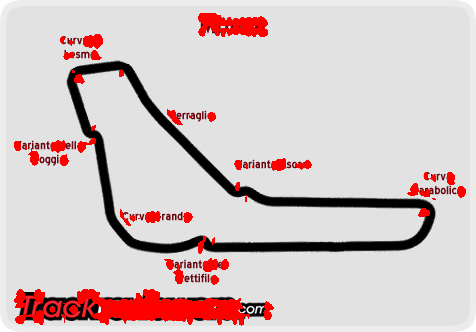

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/images/track.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray, 8, 23, 0.05)
img[dst > 0.01 * dst.max()] = [0, 0, 255]
cv2_imshow( img)
cv2.waitKey()

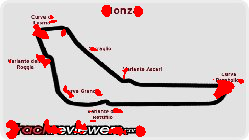

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/images/track_small.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray, 8, 23, 0.05)
img[dst > 0.01 * dst.max()] = [0, 0, 255]
cv2_imshow( img)
cv2.waitKey()

This loss of features raises an issue; we need an algorithm that works regardless of the scale
of the image. Enter **Scale-Invariant Feature Transform (SIFT)**. While the name may sound
a bit mysterious, now that we know what problem we are trying to solve, it actually makes
sense. We need a function (a transform) that will detect features (a feature transform) and
will not output different results depending on the scale of the image (a scale-invariant
feature transform). Note that SIFT does not detect keypoints (which is done with the
Difference of Gaussians (DoG); instead, it describes the region surrounding them by
means of a feature vector.

DoG is the result of applying different Gaussian filters to
the same image. Previously, we applied this type of technique for **edge detection**, and the
idea is the same here. The final result of a DoG operation contains areas of interest
(keypoints), which are then going to be described through SIFT.

Difference of Gaussians (DoG) is a feature enhancement algorithm that involves the subtraction of one Gaussian blurred version of an original image from another, **less blurred version of the original**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


you should run this line:

pip install opencv-contrib-python

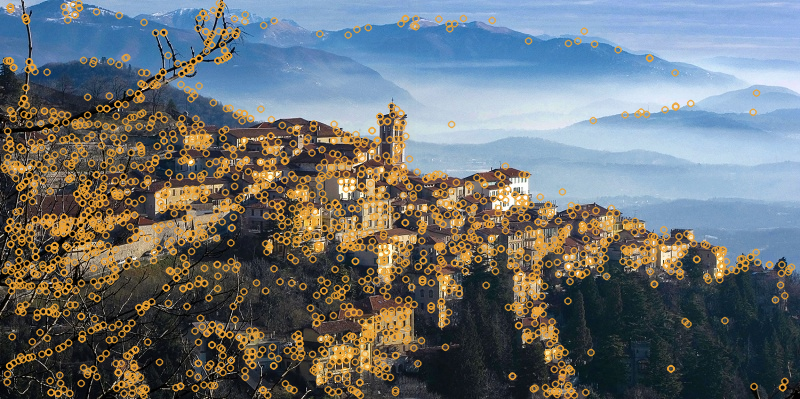

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/images/varese.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)
cv2.drawKeypoints(img, keypoints, img, (51, 163, 236),)
cv2_imshow(img)
cv2.waitKey()

create a SIFT detection object and compute the
features and descriptors of the grayscale image:

sift = cv2.xfeatures2d.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(gray, None)

The process of creating **descriptors** involves analyzing the local neighborhood around each **keypoint** in the image. The descriptor algorithm computes various properties of the neighborhood, such as gradients, orientations, or texture patterns. These properties are then quantized and encoded into a feature vector.



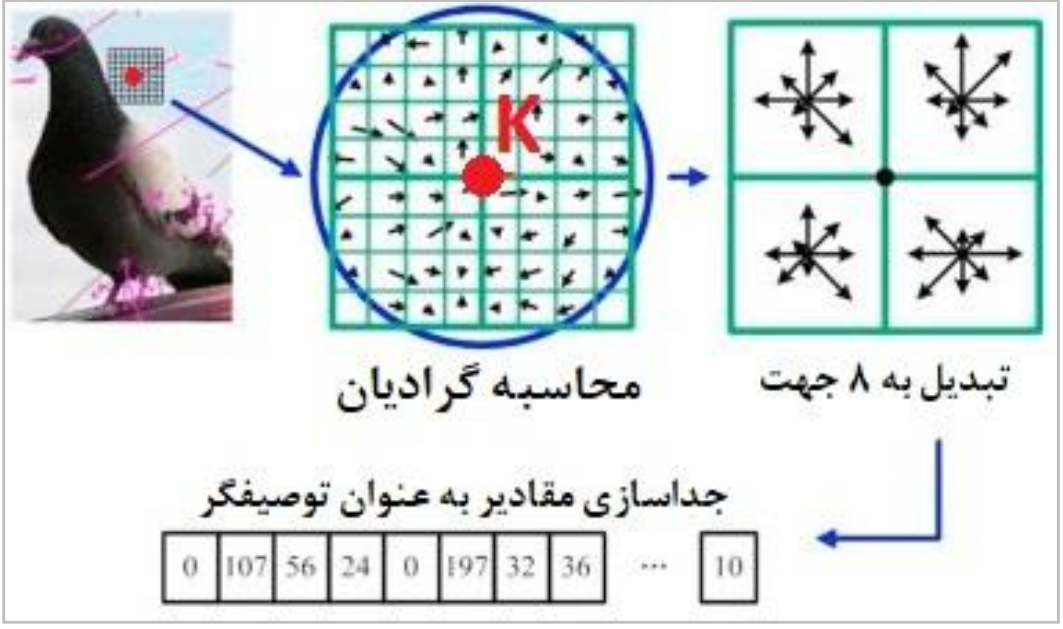

**Anatomy of a keypoint**

Each keypoint is an instance of the cv2.KeyPoint class, which has the following
properties:

* The pt (point) property contains the x and y coordinates of the keypoint in the
image.
*The size property indicates the diameter of the feature.
*The angle property indicates the orientation of the feature, as shown by the
radial lines in the preceding processed image.
*The response property indicates the strength of the keypoint. Some features are
classified by SIFT as stronger than others, and response is the property you
would check to evaluate the strength of a feature.
*The octave property indicates the layer in the image pyramid where the feature
was found. Let's briefly review the concept of an image pyramid, which we
discussed previously in Chapter 5, Detecting and Recognizing Faces, in
the Conceptualizing Haar cascades section. The SIFT algorithm operates in a similar
fashion to face detection algorithms in that it processes the same image
iteratively but alters the input at each iteration. In particular, the scale of the
image is a parameter that changes at each iteration (octave) of the algorithm.
Thus, the octave property is related to the image scale at which the keypoint
was detected.
*Finally, the class_id property can be used to assign a custom identifier to a
keypoint or a group of keypoints.

**Using ORB with FAST features and BRIEF
descriptors**

ORB mixes the techniques used in the FAST keypoint detector and the BRIEF keypoint
descriptor, so it is worth taking a quick look at FAST and BRIEF first.
ORB mixes the techniques used in the FAST keypoint detector and the BRIEF keypoint
descriptor, so it is worth taking a quick look at FAST and BRIEF first.

**FAST**

Here, we can see a 16-pixel neighborhood at two different magnifications. The pixels at
positions 1, 5, 9, and 13 correspond to the four cardinal points at the edge of the circular
neighborhood. If the neighborhood is a corner, we expect that out of these four pixels,
exactly three or exactly one will be brighter than the threshold. (Another way of saying this
is that exactly one or exactly three of them will be darker than the threshold.) If exactly two
of them are brighter than the threshold, then we have an edge, not a corner. If exactly four
or exactly zero of them are brighter than the threshold, then we have a relatively uniform
neighborhood that is neither a corner nor an edge.
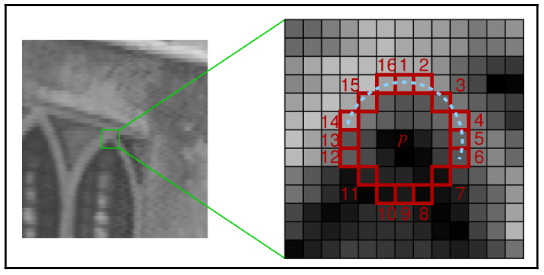

**BRIEF**

Binary Robust Independent Elementary Features (BRIEF) is a general-purpose feature point descriptor that can be combined with arbitrary detectors. It is robust to typical classes of photometric and geometric image transformations. BRIEF uses binary strings as an efficient feature point descriptor, which can be computed using simple intensity difference tests. It is highly discriminative even when using relatively few bits. The descriptor similarity can be evaluated using the Hamming distance, which is very efficient to compute


**Brute-force matching**

A brute-force matcher is a descriptor matcher that compares two sets of keypoint
descriptors and generates a result that is a list of matches. It is called brute-force because
little optimization is involved in the algorithm. For each keypoint descriptor in the first set,
the matcher makes comparisons to every keypoint descriptor in the second set. Each
comparison produces a distance value and the best match can be chosen on the basis of
least distance.


**Matching a logo in two images**

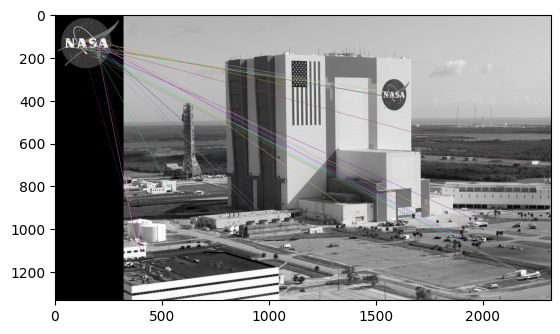

In [ ]:
import cv2
from matplotlib import pyplot as plt
# Load the images.
img0 = cv2.imread('/content/drive/MyDrive/images/nasa_logo.png',
cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/content/drive/MyDrive/images/kennedy_space_center.jpg',
cv2.IMREAD_GRAYSCALE)
# Perform ORB feature detection and description.
orb = cv2.ORB_create()
kp0, des0 = orb.detectAndCompute(img0, None)
kp1, des1 = orb.detectAndCompute(img1, None)
# Perform brute-force matching.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des0, des1)
# Sort the matches by distance.
matches = sorted(matches, key=lambda x:x.distance)
# Draw the best 25 matches.
img_matches = cv2.drawMatches(
img0, kp0, img1, kp1, matches[:25], img1,
flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# Show the matches.
plt.imshow(img_matches)
plt.show()

First, let's assume that each keypoint in our query image has, at most, one correct match in
the scene. By implication, if our query image is the NASA logo, we assume that the other
image – the scene – contains, at most, one NASA logo. Given that a query keypoint has, at
most, one correct or good match, when we consider all possible matches, we are primarily
observing bad matches. Thus, a brute-force matcher, which computes a distance score for
every possible match, can give us plenty of observations of the distance scores for bad
matches. We expect that a good match will have a significantly better (lower) distance score
than the numerous bad matches, so the scores for the bad matches can help us pick a
threshold for a good match. Such a threshold does not necessarily generalize well across
different query keypoints or different scenes, but at least it helps us on a case-by-case basis.

Now, let's consider the implementation of a modified brute-force matching algorithm that
adaptively chooses a distance threshold in the manner we have described. In the previous
section's code sample, we used the match method of the cv2.BFMatcher class in order to
get a list containing the single best (least-distance) match for each query keypoint. By doing
so, we discarded information about the distance scores of all the worse possible matches –
the kind of information we need for our adaptive approach. Fortunately, cv2.BFMatcher
also provides a knnMatch method, which accepts an argument, k, that specifies the
maximum number of best (least-distance) matches that we want to retain for each query
keypoint. (In some cases, we may get fewer matches than the maximum.) KNN stands for
k-nearest neighbors.

We will use the knnMatch method to request a list of the two best matches for each query
keypoint. Based on our assumption that each query keypoint has, at most, one correct
match, we are confident that the second-best match is wrong. We multiply the second-best
match's distance score by a value less than 1 in order to obtain the threshold.
Then, we accept the best match as a good match only if its distant score is less than the
threshold.

 **Filtering matches using K-Nearest
Neighbors and the ratio test**


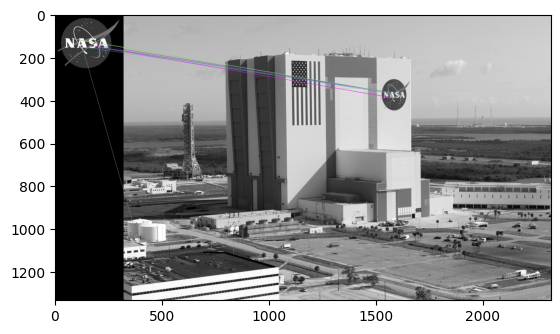

In [ ]:
import cv2
from matplotlib import pyplot as plt
# Load the images.
img0 = cv2.imread('/content/drive/MyDrive/images/nasa_logo.png',
cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/content/drive/MyDrive/images/kennedy_space_center.jpg',
cv2.IMREAD_GRAYSCALE)
# Perform ORB feature detection and description.
orb = cv2.ORB_create()
kp0, des0 = orb.detectAndCompute(img0, None)
kp1, des1 = orb.detectAndCompute(img1, None)
# Perform brute-force KNN matching.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
pairs_of_matches = bf.knnMatch(des0, des1, k=2)
# Sort the pairs of matches by distance.
pairs_of_matches = sorted(pairs_of_matches, key=lambda x:x[0].distance)
# Apply the ratio test.
matches = [x[0] for x in pairs_of_matches
if len(x) > 1 and x[0].distance < 0.8 * x[1].distance]
# Draw the best 25 matches.
img_matches = cv2.drawMatches(
img0, kp0, img1, kp1, matches[:25], img1,
flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# Show the matches.
plt.imshow(img_matches)
plt.show()

knnMatch returns a list of lists; each inner list contains at least one match and no more than
k matches, sorted from best (least distance) to worst.

**Matching with FLANN**

FLANN stands for Fast Library for Approximate Nearest Neighbors. FlannBasedMatcher is also used to match or search for the features of one image to another image. this function is available in the OpenCV library.  It uses Nearest Neighbors Approach and usually runs faster than BruteForceMatcher for various datasets.
FLANN's authors claim that it is 10 times faster than other nearest-neighbor search
software for many datasets.

FLANN (Fast Library for Approximate Nearest Neighbors) is a collection of many optimized algorithms that help to search for fast nearest neighbors. Some of the available algorithms for FLANN-based matching include:

 * **Randomized k-d Tree**: An efficient approximate nearest neighbor search algorithm.Randomized k-d Tree: This algorithm is known for its fast performance when searching for nearest neighbors in **large datasets**. It can be a good choice when **speed is a priority** and precision can be compromised.
 * **Priority-based K-Means**: Another efficient approximate nearest neighbor search algorithm.Priority-based K-Means: This algorithm is another efficient approximate nearest neighbor search algorithm. It may be a suitable choice when you need **better precision** in finding matches, even if it comes at the cost of slightly slower performance.


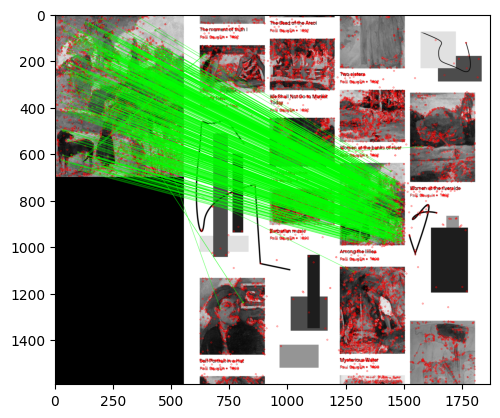

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img0 = cv2.imread('/content/drive/MyDrive/images/gauguin_entre_les_lys.jpg',
cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/content/drive/MyDrive/images/gauguin_paintings.png',
cv2.IMREAD_GRAYSCALE)
# Perform SIFT feature detection and description.
sift = cv2.xfeatures2d.SIFT_create()
kp0, des0 = sift.detectAndCompute(img0, None)
kp1, des1 = sift.detectAndCompute(img1, None)
# Define FLANN-based matching parameters.
FLANN_INDEX_KDTREE = 1
#a kernel density tree (kd-tree) indexing algorithm with five trees
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
# Perform FLANN-based matching.
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)
# Prepare an empty mask to draw good matches.
mask_matches = [[0, 0] for i in range(len(matches))]
# Populate the mask based on David G. Lowe's ratio test.
for i, (m, n) in enumerate(matches):
  if m.distance < 0.7 * n.distance:
    mask_matches[i]=[1, 0]
# Draw the matches that passed the ratio test.
img_matches = cv2.drawMatchesKnn(
img0, kp0, img1, kp1, matches, None,
matchColor=(0, 255, 0), singlePointColor=(255, 0, 0),
matchesMask=mask_matches, flags=0)
# Show the matches.
plt.imshow(img_matches)
plt.show()




we are using a
kernel density tree (kd-tree) indexing algorithm with five trees, which FLANN can process
in parallel. (The FLANN documentation recommends between one tree, which would offer
no parallelism, and 16 trees, which would offer a high degree of parallelism if the system
could exploit it.)

We are performing 50 checks or traversals of each tree. A greater number of checks can
provide greater accuracy but at a greater computational cost.


After performing FLANN-based matching, we apply Lowe's ratio test with a multiplier of
0.7. we
assembled a list called mask_matches, in which each element is a sublist of length k (the
same k that we passed to knnMatch). If a match is good, we set the corresponding element
of the sublist to 1; otherwise, we set it to 0.

For example, if we have mask_matches = [[0, 0], [1, 0]], this means that we have
two matched keypoints; for the first keypoint, the best and second-best matches are both
bad, while for the second keypoint, the best match is good but the second-best match is
bad. Remember, we assume that all the second-best matches are bad. We use the following
code to apply the ratio test and build the mask:

In [ ]:

l1 = ["eat", "sleep", "repeat"]
s1 = "geek"

# creating enumerate objects
obj1 = enumerate(l1)
obj2 = enumerate(s1)

print ("Return type:", type(obj1))
print (list(enumerate(l1)))

# changing start index to 2 from 0
print (list(enumerate(s1, 2)))

Return type: <class 'enumerate'>
[(0, 'eat'), (1, 'sleep'), (2, 'repeat')]
[(2, 'g'), (3, 'e'), (4, 'e'), (5, 'k')]


 **Performing homography with FLANN-based
matches**

Homography is a transformation that maps points from one plane to another.The homography matrix is a 3x3 matrix but with 8 DoF (degrees of freedom) as it is estimated up to a scale.Homography can be useful in various applications such as camera pose estimation from coplanar points for augmented reality with marker, perspective removal/correction, and panorama stitching.

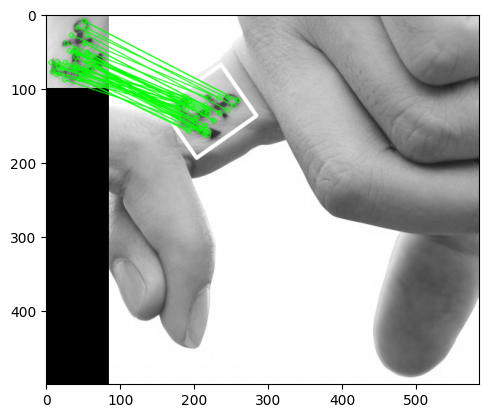

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img0 = cv2.imread('/content/drive/MyDrive/images/query.png',
cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/content/drive/MyDrive/images/anchor-man.png',
cv2.IMREAD_GRAYSCALE)
# Perform SIFT feature detection and description.
sift = cv2.xfeatures2d.SIFT_create()
kp0, des0 = sift.detectAndCompute(img0, None)
kp1, des1 = sift.detectAndCompute(img1, None)
# Define FLANN-based matching parameters.
FLANN_INDEX_KDTREE = 1
#a kernel density tree (kd-tree) indexing algorithm with five trees
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
# Perform FLANN-based matching.
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)
# Find all the good matches as per Lowe's ratio test.
good_matches = []
for m, n in matches:
  if m.distance < 0.7 * n.distance:
    good_matches.append(m)
MIN_NUM_GOOD_MATCHES = 10
if len(good_matches) >= MIN_NUM_GOOD_MATCHES:
  src_pts = np.float32([kp0[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)

  dst_pts = np.float32([kp1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
  mask_matches = mask.ravel().tolist()
  h, w = img0.shape
  src_corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

  dst_corners = cv2.perspectiveTransform(src_corners, M)
  dst_corners = dst_corners.astype(np.int32)
# Draw the bounds of the matched region based on the homography.
  num_corners = len(dst_corners)
  for i in range(num_corners):
    x0, y0 = dst_corners[i][0]
    if i == num_corners - 1:
      next_i = 0
    else:
      next_i = i + 1
    x1, y1 = dst_corners[next_i][0]
    cv2.line(img1, (x0, y0), (x1, y1), 255, 3, cv2.LINE_AA)
# Draw the matches that passed the ratio test.
  img_matches = cv2.drawMatches(
        img0, kp0, img1, kp1, good_matches, None,
        matchColor=(0, 255, 0), singlePointColor=None,
        matchesMask=mask_matches, flags=2)

    # Show the homography and good matches.
  plt.imshow(img_matches)
  plt.show()
else:
    print("Not enough matches good were found - %d/%d" % \
          (len(good_matches), MIN_NUM_GOOD_MATCHES))






Technically, we can calculate the homography with as few as four matches.2.
However, if any of these four matches is flawed, it will throw off the accuracy of
the result. A more practical minimum is 10. Given the extra matches, the
homography-finding algorithm can discard some outliers in order to produce a
result that closely fits a substantial subset of the matches. Thus, we proceed to
check whether we have at least 10 good matches:
MIN_NUM_GOOD_MATCHES = 10
if len(good_matches) >= MIN_NUM_GOOD_MATCHES:

If this condition has been satisfied, we look up the 2D coordinates of the matched3.
keypoints and place these coordinates in two lists of floating-point coordinate
pairs. One list contains the keypoint coordinates in the query image, while the
other list contains the matching keypoint coordinates in the scene:

src_pts = np.float32(
[kp0[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32(
[kp1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

The reshape(-1, 1, 2) function is used to reshape a 2D array into a 3D array with one column and two elements in each row. It is commonly used in machine learning tasks to transform the input data into the desired shape for further processing. The -1 argument indicates that the size of that dimension should be automatically calculated based on the other dimensions of the array.

Here is an example to illustrate how reshape(-1, 1, 2) works:


In [ ]:
import numpy as np

# Create a 2D array
arr = np.array([[1, 2], [3, 4], [5, 6]])

# Reshape the array
reshaped_arr = arr.reshape(-1, 1, 2)

print(reshaped_arr)


[[[1 2]]

 [[3 4]]

 [[5 6]]]


The code M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0) is used to find the homography matrix M and the mask mask using the RANSAC algorithm in OpenCV. The findHomography function is commonly used in computer vision tasks, such as image stitching and object tracking, to estimate the transformation between two sets of corresponding points.

Here is an example to illustrate how findHomography works:

In [ ]:
import cv2
import numpy as np

# Define source and destination points
src_pts = np.array([[50, 50], [200, 50], [200, 200], [50, 200]])
dst_pts = np.array([[10, 100], [200, 50], [200, 200], [100, 250]])

# Find homography matrix and mask
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

print("Homography matrix:")
print(M)
print("Mask:")
print(mask)


Homography matrix:
[[ 2.77777778e+00  2.00000000e+00 -2.22222222e+02]
 [-3.88888889e-01  4.16666667e+00 -2.22222222e+01]
 [ 3.33333333e-03  1.00000000e-02  1.00000000e+00]]
Mask:
[[1]
 [1]
 [1]
 [1]]


HOMOGRAPHY MATRIX

Robust matching and homography with the
RANSAC algorithm
Random Sample Consensus (RANSAC) is an iterative non-deterministic algorithm for the
robust estimation of parameters of a mathematical model from several random subsets of
inliers from the complete dataset (containing outliers). In this recipe, we will use
the skimage.measure module's implementation of the RANSAC algorithm. Each iteration
of the RANSAC algorithm does the following:

  * It selects a random sample of a size of min_samples from the original data.
(hypothetical inliers) and ensures that the sample dataset is valid for fitting the
model.

  * It fits a model (that is, estimate the model parameters) to the sampled dataset and.
ensures that the estimated model is valid.

  * It checks whether the estimated model fits to all of the other data points.3.
Computes the consensus set (inliers) and the outliers from all of the data
points by computing some model-specific loss function (for example, the
residuals) to the estimated model. inliers are defined to be the data points that
have the smaller residuals than the specified residual threshold.

  * It saves the model (defined by the estimated model parameters) as the best model4.
(seen so far) if the number of samples in the consensus set (inliers) is maximal.
If there is a tie (in terms of the number of inliers), the model that has
fewer residuals is considered the best model.

The preceding steps are repeatedly executed either for a maximum number of times
(defined by max_trials) or until one of the stopping criteria (specified
using stop_sample_num, stop_probability, and so on) is met. The final model is
obtained using all inlier samples corresponding to the best model found so far. The
number of required trials (or random samples chosen) N, so that, with probability p, at least
one random sample is free from outliers, is given by the expression shown in the following
diagram (a typical value of p we want to have is 0.99 or higher):
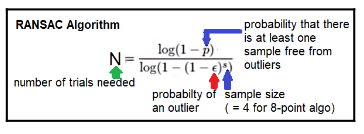

**Image mosaicing (panorama)**

4.6.0


<ipython-input-7-9c2cb96b5aa0>:193: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(images),i+1), plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Image {}'.format(i+1), size=15)


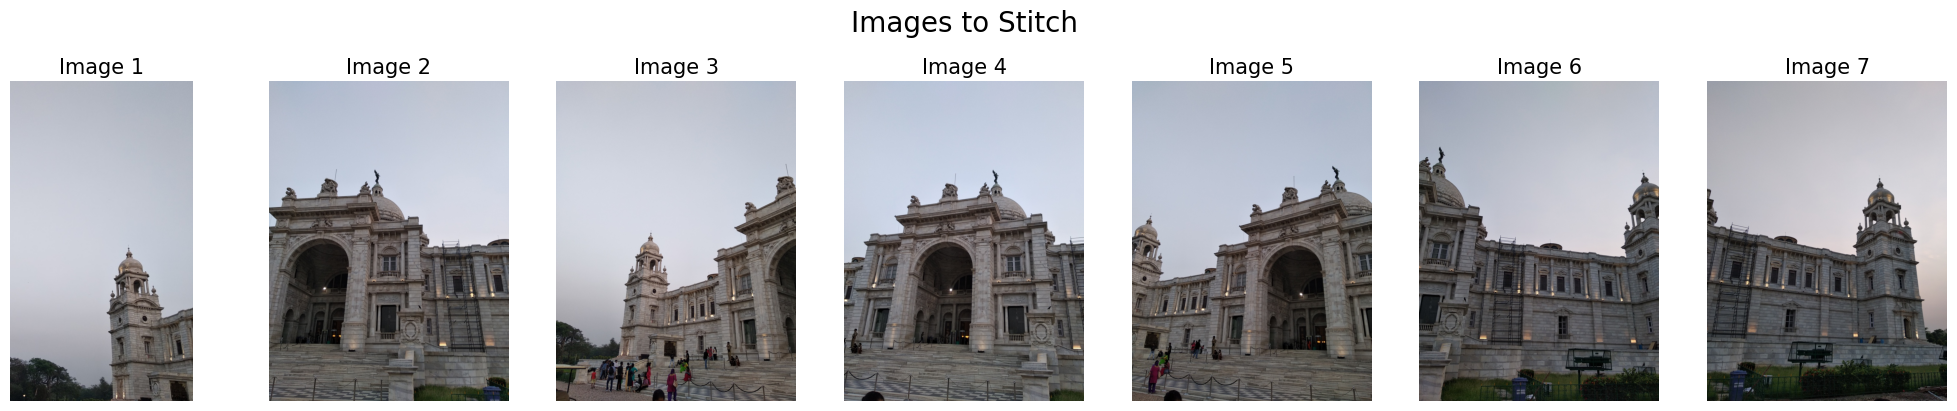

Stitching images 1, 2
Stitching images 2, 3
Stitching images 3, 4
Stitching images 4, 5
Stitching images 5, 6
Stitching images 6, 7


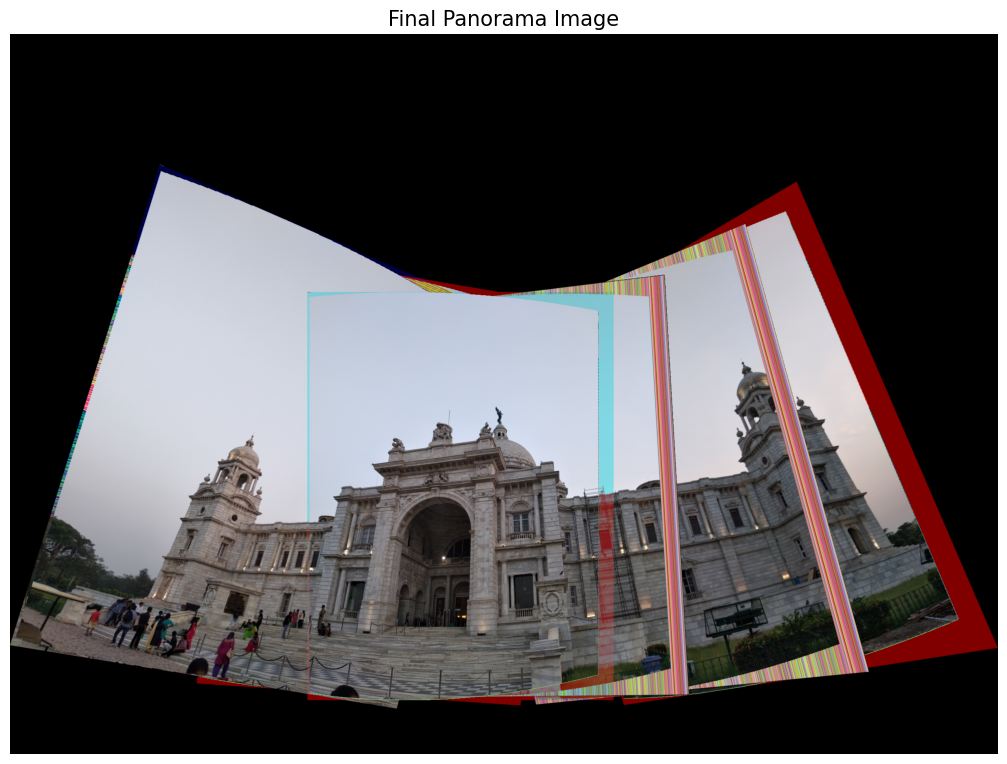

In [ ]:
import cv2
# for this problem let's work with opencv 3.4.2.16
print(cv2.__version__)
# 3.4.2
# pip install opencv-contrib-python==3.4.2.16
# pip install opencv-python==3.4.2.16
import numpy as np
from matplotlib import pyplot as plt
import math
import glob

def compute_homography(image1, image2, bff_match=False):

    sift = cv2.xfeatures2d.SIFT_create(edgeThreshold=10, sigma=1.5, contrastThreshold=0.08)

    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)

    # Brute force matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, trainDescriptors=des2, k=2)

    # Lowes Ratio
    good_matches = []
    for m, n in matches:
        if m.distance < .75 * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])\
        .reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])\
        .reshape(-1, 1, 2)

    if len(src_pts) > 4:
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5)
    else:
        H = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
    return H


def warp_image(image, H):
     #BGRA is a color space that stands for Blue, Green, Red, Alpha.
     #The values of the Alpha channel range from 0 to 255, where 0 represents complete transparency and 255 represents complete opacity.

    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    h, w, _ = image.shape

    # Find min and max x, y of new image
    # shape 3 * 4
    p = np.array([[0, w, w, 0], [0, 0, h, h], [1, 1, 1, 1]])
    # The result is stored in the array p_prime, which represents the transformed coordinates of the four points.
    p_prime = np.dot(H, p)
    # This line calculates the y-coordinates of the transformed points by dividing the second row of p_prime by the third row.
    yrow = p_prime[1] / p_prime[2]
    # This line calculates the x-coordinates of the transformed points by dividing the first row of p_prime by the third row.
    xrow = p_prime[0] / p_prime[2]
    ymin = min(yrow)
    xmin = min(xrow)
    ymax = max(yrow)
    xmax = max(xrow)

    # Create a new matrix that removes offset and multiply by homography
    new_mat = np.array([[1, 0, -1 * xmin], [0, 1, -1 * ymin], [0, 0, 1]])
    H = np.dot(new_mat, H)

    # height and width of new image frame
    height = int(round(ymax - ymin))
    width = int(round(xmax - xmin))
    size = (width, height)
    # Do the warp
    warped = cv2.warpPerspective(src=image, M=H, dsize=size)

    return warped, (int(xmin), int(ymin))

def cylindrical_warp_image(img, H):

    h, w = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h, w))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h*w, 3) # to homog
    Hinv = np.linalg.inv(H)
    X = Hinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w*h, 3)
    B = H.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w) | (B[:,1] < 0) | (B[:,1] >= h)] = -1
    B = B.reshape(h,w,-1)

    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA) # for transparent borders...
    # warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_TRANSPARENT)

def create_mosaic(images, origins):
    # find central image
    for i in range(0, len(origins)):
        if origins[i] == (0, 0):
            central_index = i
            break

    central_image = images[central_index]
    central_origin = origins[central_index]

    # zip origins and images together
    zipped = list(zip(origins, images))

    # sort by distance from origin (highest to lowest)
    func = lambda x: math.sqrt(x[0][0] ** 2 + x[0][1] ** 2)
    dist_sorted = sorted(zipped, key=func, reverse=True)
    # sort by x value
    x_sorted = sorted(zipped, key=lambda x: x[0][0])
    # sort by y value
    y_sorted = sorted(zipped, key=lambda x: x[0][1])

    # determine the coordinates in the new frame of the central image
    if x_sorted[0][0][0] > 0:
        cent_x = 0  # leftmost image is central image
    else:
        cent_x = abs(x_sorted[0][0][0])

    if y_sorted[0][0][1] > 0:
        cent_y = 0  # topmost image is central image
    else:
        cent_y = abs(y_sorted[0][0][1])

    # make a new list of the starting points in new frame of each image
    spots = []
    for origin in origins:
        spots.append((origin[0]+cent_x, origin[1] + cent_y))

    zipped = zip(spots, images)

    # get height and width of new frame
    total_height = 0
    total_width = 0

    for spot, image in zipped:
        total_width = max(total_width, spot[0]+image.shape[1])
        total_height = max(total_height, spot[1]+image.shape[0])

    # print "height ", total_height
    # print "width ", total_width

    # new frame of panorama
    stitch = np.zeros((total_height, total_width, 4), np.uint8)

    # stitch images into frame by order of distance
    for image in dist_sorted:

        offset_y = image[0][1] + cent_y
        offset_x = image[0][0] + cent_x
        end_y = offset_y + image[1].shape[0]
        end_x = offset_x + image[1].shape[1]

        ####
        stitch_cur = stitch[offset_y:end_y, offset_x:end_x, :4]
        stitch_cur[image[1]>0] = image[1][image[1]>0]
        ####

        #stitch[offset_y:end_y, offset_x:end_x, :4] = image[1]

    return stitch

def create_panorama(images, center):

    h,w,_ = images[0].shape
    f = 1000 # 800
    H = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]])
    for i in range(len(images)):
        images[i] = cylindrical_warp_image(images[i], H)

    panorama = None
    for i in range(center):
        print('Stitching images {}, {}'.format(i+1, i+2))
        image_warped, image_origin = warp_image(images[i], compute_homography(images[i + 1], images[i]))
        panorama = create_mosaic([image_warped, images[i+1]], [image_origin, (0,0)])
        images[i + 1] = panorama

    #print('Done left part')

    for i in range(center, len(images)-1):
        print('Stitching images {}, {}'.format(i+1, i+2))
        image_warped, image_origin = warp_image(images[i+1], compute_homography(images[i], images[i + 1]))
        panorama = create_mosaic([images[i], image_warped], [(0,0), image_origin])
        images[i + 1] = panorama

    #print('Done right part')
    return panorama

images = [ cv2.cvtColor(cv2.imread(img), cv2.COLOR_RGB2RGBA) for img in glob.glob('/content/drive/MyDrive/images/victoria*.png')]

plt.figure(figsize=(20,4))
plt.subplots_adjust(top = 0.8, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0.05)
plt.margins(0,0)
for i in range(len(images)):
    plt.subplot(1,len(images),i+1), plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Image {}'.format(i+1), size=15)
plt.suptitle('Images to Stitch', size=20)
plt.show()

center = len(images) // 2
#print(len(images), center)

panorama = create_panorama(images, center)

plt.figure(figsize=(20,8))
plt.subplots_adjust(top = 0.9, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Final Panorama Image', size=15)
plt.show()

4.8.0
Loading images...
Number of images to stitch: 7


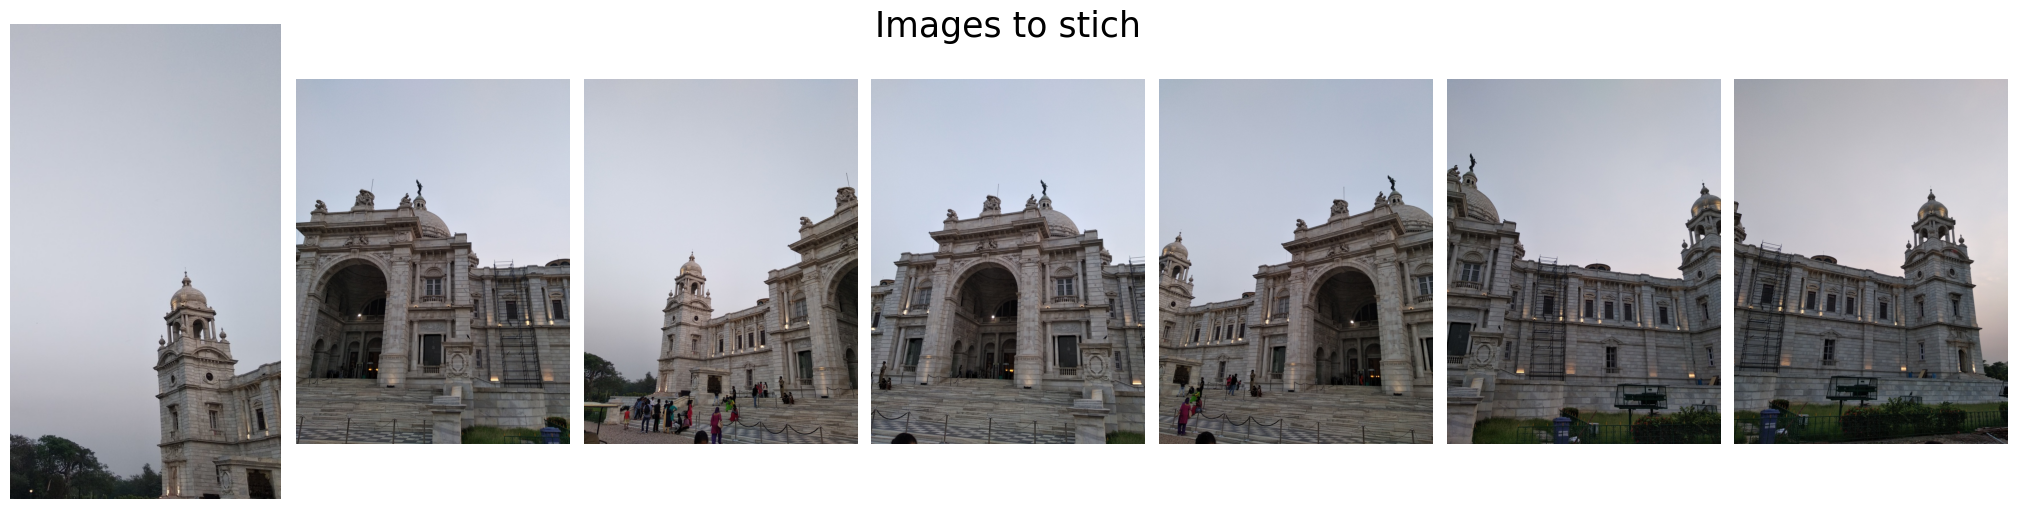

Stitching images...


AttributeError: ignored

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pylab as plt

print(cv2.__version__)
# 3.4.2

# grab the paths to the input images and initialize our images list
print("Loading images...")
images = [ cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in glob.glob('images/victoria*.png')]
print('Number of images to stitch: {}'.format(len(images)))
fig = plt.figure(figsize=(20, 5))
for i in range(len(images)):
    plt.subplot(1,len(images),i+1)
    plt.imshow(images[i])
    plt.axis('off')
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95, hspace=0.05, wspace=0.05)
plt.suptitle('Images to stich', size=25)
plt.show()

# initialize OpenCV's image sticher object and then perform the image
# stitching
print("Stitching images...")
stitcher = cv2.createStitcher()
(status, stitched) = stitcher.stitch(images)
print(status)

plt.figure(figsize=(20,10))
plt.imshow(stitched), plt.axis('off'), plt.title('Final Panorama Image', size=20)
plt.show()